In [1]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import gensim.downloader as api
from PIL import Image
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

In [2]:
BATCH_SIZE=64

In [3]:
train_ds,val_ds,test_ds=tfds.load('imdb_reviews', split=['train', 'test[:50%]', 'test[50%:]'],as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYLZD88/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYLZD88/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteYLZD88/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [4]:
for review,label in val_ds.take(3):
  print(review)
  print(label)

tf.Tensor(b"There are films that make careers. For George Romero, it was NIGHT OF THE LIVING DEAD; for Kevin Smith, CLERKS; for Robert Rodriguez, EL MARIACHI. Add to that list Onur Tukel's absolutely amazing DING-A-LING-LESS. Flawless film-making, and as assured and as professional as any of the aforementioned movies. I haven't laughed this hard since I saw THE FULL MONTY. (And, even then, I don't think I laughed quite this hard... So to speak.) Tukel's talent is considerable: DING-A-LING-LESS is so chock full of double entendres that one would have to sit down with a copy of this script and do a line-by-line examination of it to fully appreciate the, uh, breadth and width of it. Every shot is beautifully composed (a clear sign of a sure-handed director), and the performances all around are solid (there's none of the over-the-top scenery chewing one might've expected from a film like this). DING-A-LING-LESS is a film whose time has come.", shape=(), dtype=string)
tf.Tensor(1, shape=(),

In [5]:
def standardization(input_data):
    '''
    Input: raw reviews
    output: standardized reviews
    '''
    lowercase=tf.strings.lower(input_data)
    no_tag=tf.strings.regex_replace(lowercase,"<[^>]+>","")
    output=tf.strings.regex_replace(no_tag,"[%s]"%re.escape(string.punctuation),"")

    return output

In [6]:
VOCAB_SIZE=10000  ### take first most freq. 10000 words as tokens
SEQUENCE_LENGTH=250  ### take sentence upto lenght 250
EMBEDDING_DIM=300  ### output vector dimension

In [7]:
### TextVectorization:  tokenization and numericalization

vectorize_layer=TextVectorization(
    standardize=standardization,
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=SEQUENCE_LENGTH)

In [8]:
training_data=train_ds.map(lambda x,y:x)### input x and y and outputx
vectorize_layer.adapt(training_data)#### adapt the vectorize_layer to the training data

In [9]:
len(vectorize_layer.get_vocabulary())

10000

In [10]:
def vectorizer(review,label):
    return vectorize_layer(review),label

In [11]:
train_dataset=train_ds.map(vectorizer)
val_dataset=val_ds.map(vectorizer)

In [12]:
for review,label in train_dataset.take(1):
  print(review)
  print(label)

tf.Tensor(
[  10   13   33  411  384   17   89   26    1    8   32 1337 3521   40
  491    1  192   22   84  149   18   10  215  317   26   64  239  212
    8  484   54   64   84  111   95   21 5502   10   91  637  737   10
   17    7   33  393 9554  169 2443  406    2   87 1205  135   65  142
   52    2    1 7408   65  245   64 2832   16    1 2851    1    1 1415
 4969    3   39    1 1567   15 3521   13  156   18    4 1205  881 7874
    8    4   17   12   13 4037    5   98  145 1234   11  236  696   12
   48   22   91   37   10 7285  149   37 1337    1   49  396   11   95
 1148  841  140    9    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0 

In [13]:
for review,label in train_ds.take(1):
  print(review)
  print(label)

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [14]:
vectorize_layer.get_vocabulary()[10]

'this'

In [15]:
vectorize_layer.get_vocabulary()[1]  ### "lured" taken is not present in first 10000 words of vocab.

'[UNK]'

In [16]:
train_dataset=train_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset=val_dataset.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

## SimpleRNN

In [17]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),
    SimpleRNN(32),  ## nodes
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 64)           640000    
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                3104      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 643137 (2.45 MB)
Trainable params: 643137 (2.45 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [19]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
391/391 [==============================] - 144s 360ms/step - loss: 0.6919 - accuracy: 0.5231 - val_loss: 0.6913 - val_accuracy: 0.5198
Epoch 2/10
391/391 [==============================] - 94s 240ms/step - loss: 0.6906 - accuracy: 0.5144 - val_loss: 0.6928 - val_accuracy: 0.5076
Epoch 3/10
391/391 [==============================] - 95s 242ms/step - loss: 0.6867 - accuracy: 0.5358 - val_loss: 0.6915 - val_accuracy: 0.5161
Epoch 4/10
391/391 [==============================] - 93s 239ms/step - loss: 0.6773 - accuracy: 0.5715 - val_loss: 0.6907 - val_accuracy: 0.5434
Epoch 5/10
391/391 [==============================] - 94s 240ms/step - loss: 0.6496 - accuracy: 0.6419 - val_loss: 0.6719 - val_accuracy: 0.6076
Epoch 6/10
391/391 [==============================] - 99s 253ms/step - loss: 0.6184 - accuracy: 0.6779 - val_loss: 0.6564 - val_accuracy: 0.6348
Epoch 7/10
391/391 [==============================] - 93s 238ms/step - loss: 0.5555 - accuracy: 0.7560 - val_loss: 0.6441 - val_a

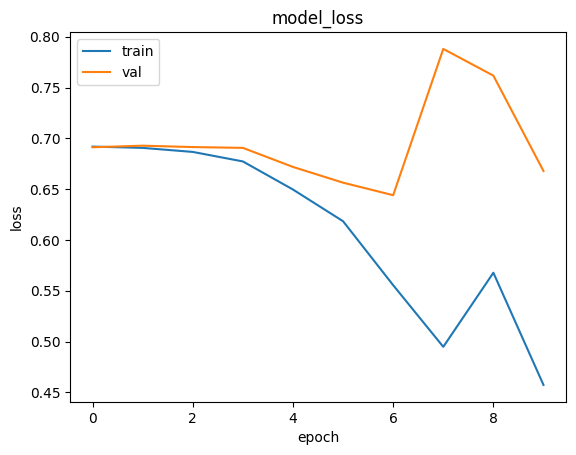

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

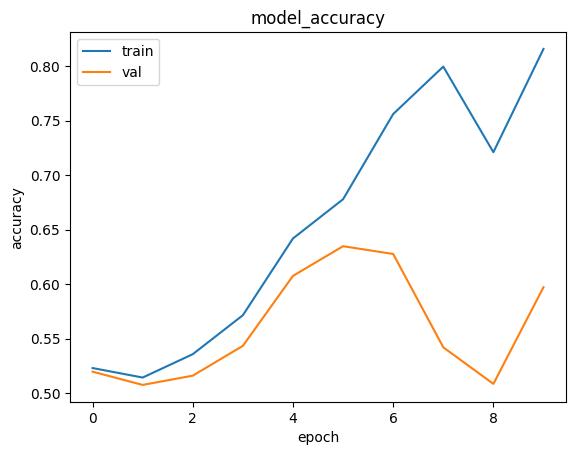

In [21]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation over test data

In [22]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 7s 36ms/step - loss: 0.6656 - accuracy: 0.5994


[0.6655938029289246, 0.5994399785995483]

## LSTM Model

In [23]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    LSTM(64,return_sequences=True),
    LSTM(32),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 250, 64)           640000    
                                                                 
 lstm (LSTM)                 (None, 250, 64)           33024     
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 687617 (2.62 MB)
Trainable params: 68761

In [24]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
391/391 [==============================] - 45s 103ms/step - loss: 0.6930 - accuracy: 0.5106 - val_loss: 0.6930 - val_accuracy: 0.5160
Epoch 2/10
391/391 [==============================] - 13s 34ms/step - loss: 0.6901 - accuracy: 0.5392 - val_loss: 0.6420 - val_accuracy: 0.6136
Epoch 3/10
391/391 [==============================] - 16s 40ms/step - loss: 0.4204 - accuracy: 0.8229 - val_loss: 0.3580 - val_accuracy: 0.8486
Epoch 4/10
391/391 [==============================] - 16s 40ms/step - loss: 0.2723 - accuracy: 0.9006 - val_loss: 0.3350 - val_accuracy: 0.8646
Epoch 5/10
391/391 [==============================] - 14s 35ms/step - loss: 0.2315 - accuracy: 0.9198 - val_loss: 0.3549 - val_accuracy: 0.8607
Epoch 6/10
391/391 [==============================] - 13s 34ms/step - loss: 0.2087 - accuracy: 0.9294 - val_loss: 0.3695 - val_accuracy: 0.8610
Epoch 7/10
391/391 [==============================] - 13s 34ms/step - loss: 0.1840 - accuracy: 0.9416 - val_loss: 0.3912 - val_accuracy

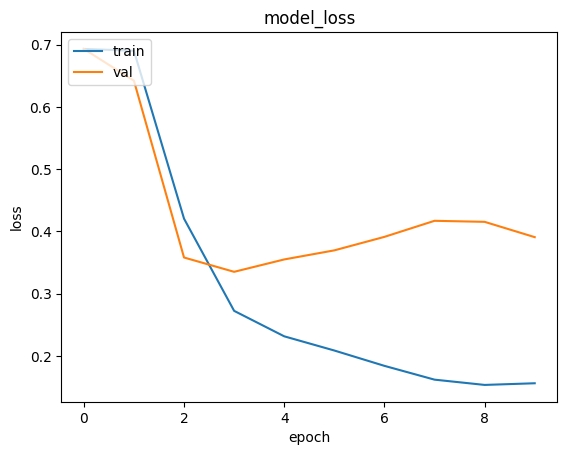

In [26]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

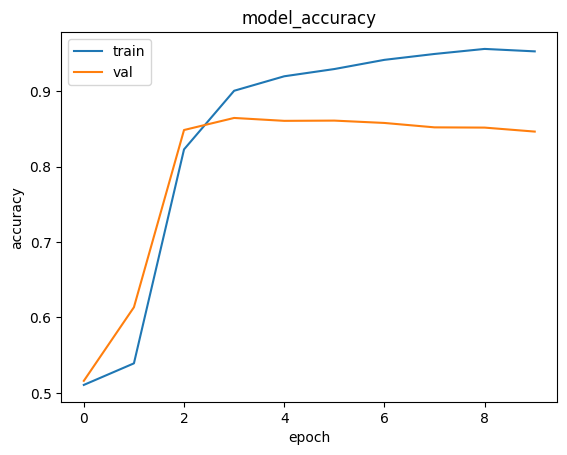

In [27]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 3s 15ms/step - loss: 0.3836 - accuracy: 0.8477


[0.3836296498775482, 0.8476799726486206]

In [29]:
model.predict(test_dataset)

196/196 [==============================] - 4s 17ms/step


array([[0.08044543],
       [0.5855533 ],
       [0.9282316 ],
       ...,
       [0.02148473],
       [0.9856954 ],
       [0.9875695 ]], dtype=float32)

### GRU Model

In [30]:
EMBEDDING_DIM=64
model=tf.keras.models.Sequential([
    Input(shape=(SEQUENCE_LENGTH,)),
    Embedding(VOCAB_SIZE,EMBEDDING_DIM),

    GRU(64,return_sequences=True),
    GRU(32),

    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid'),
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 250, 64)           640000    
                                                                 
 gru (GRU)                   (None, 250, 64)           24960     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 64)                2112      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 676545 (2.58 MB)
Trainable params: 67654

In [31]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [32]:
history=model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=10)

Epoch 1/10
391/391 [==============================] - 43s 101ms/step - loss: 0.6932 - accuracy: 0.5038 - val_loss: 0.6931 - val_accuracy: 0.4992
Epoch 2/10
391/391 [==============================] - 13s 33ms/step - loss: 0.6928 - accuracy: 0.5114 - val_loss: 0.6929 - val_accuracy: 0.5047
Epoch 3/10
391/391 [==============================] - 13s 33ms/step - loss: 0.6899 - accuracy: 0.5272 - val_loss: 0.6902 - val_accuracy: 0.5154
Epoch 4/10
391/391 [==============================] - 13s 34ms/step - loss: 0.5316 - accuracy: 0.7070 - val_loss: 0.3798 - val_accuracy: 0.8342
Epoch 5/10
391/391 [==============================] - 13s 34ms/step - loss: 0.2956 - accuracy: 0.8874 - val_loss: 0.3378 - val_accuracy: 0.8582
Epoch 6/10
391/391 [==============================] - 13s 34ms/step - loss: 0.2416 - accuracy: 0.9163 - val_loss: 0.3567 - val_accuracy: 0.8519
Epoch 7/10
391/391 [==============================] - 13s 33ms/step - loss: 0.2151 - accuracy: 0.9272 - val_loss: 0.3866 - val_accuracy

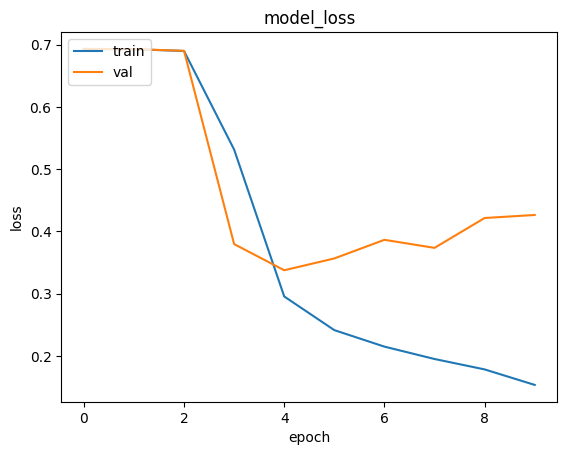

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

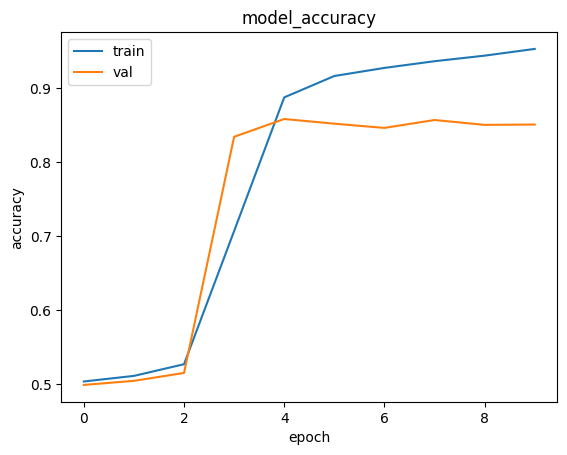

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [35]:
test_dataset=test_ds.map(vectorizer)
test_dataset=test_dataset.batch(BATCH_SIZE)
model.evaluate(test_dataset)

196/196 [==============================] - 4s 22ms/step - loss: 0.4268 - accuracy: 0.8472


[0.4268101453781128, 0.8471999764442444]

In [36]:
model.predict(test_dataset)

196/196 [==============================] - 4s 15ms/step


array([[0.0605278 ],
       [0.17910576],
       [0.9373067 ],
       ...,
       [0.00757917],
       [0.9936237 ],
       [0.9947743 ]], dtype=float32)